## setup

In [2]:
%matplotlib inline

In [3]:
from numpy import array, asarray, arange, sqrt, vstack, hstack, ones
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
from thunder import Images, SourceModel
from showit import image, tile
import matplotlib.animation as animation

In [5]:
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')

## load data

In [6]:
datapath = '/tier2/freeman/Nick/lfov.calibration/2015-12-14/run-06-zoom-walls/'

In [7]:
data = tsc.loadImages(datapath + 'images')
data = data.filterOnKeys(lambda k: k<6000)

In [8]:
frameRate = 9.66
pxPerUm = 512.0/600

## registration

In [9]:
from thunder import Registration

In [10]:
reg = Registration('planarcrosscorr')
reg.prepare(data)
model = reg.fit(data)
corrected = model.transform(data)

In [11]:
corrected.cache()
corrected.count();

In [12]:
mean = corrected.mean()

## load sources

In [13]:
auto = [tsc.loadSources(os.path.join(datapath,'sources',('sourcesAutoDense-%i.json' % plane))) for plane in range(4)]

In [14]:
drawn = [tsc.loadSources(os.path.join(datapath,'sources',('sourcesDrawn-%i.json' % plane))) for plane in range(4)]

## Color sources

In [15]:
from numpy import maximum, where
from regional import one, many

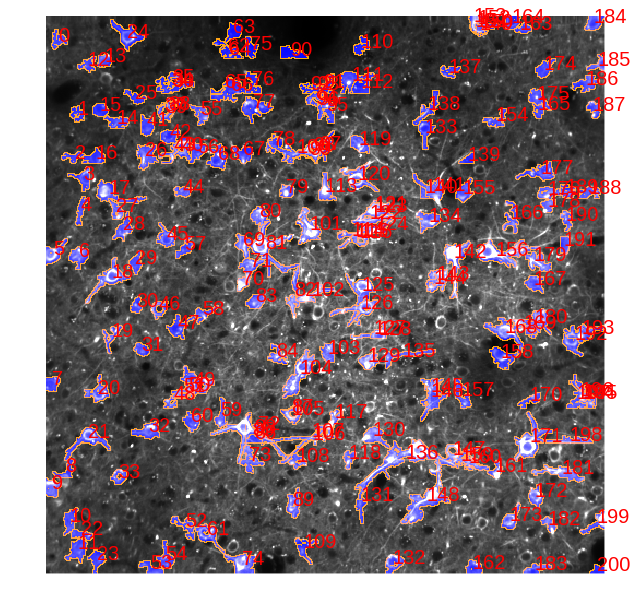

In [16]:
p = 0
region = many(auto[p].coordinates)

background = mean[:,:,p].astype('float').clip(0,2000)/2000
background = array([background for i in range(3)]).swapaxes(0,1).swapaxes(1,2)

masks = region.mask((512,512), background = 'black', fill='blue', stroke='orange')
blend = maximum(background,masks)

umPerPxX = 600.0/512
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
im = image(blend, ax=ax)
plt.xlim([0, mean.shape[1]]);
plt.ylim([mean.shape[0], 0]);
for s in range(region.count):
    plt.annotate(s=str(s), xy=[region.center[s][1],region.center[s][0]], color='r', size = 20);
#plt.savefig('%s-plane-%s.eps' % (datapath + 'mean/ROIs', plane))

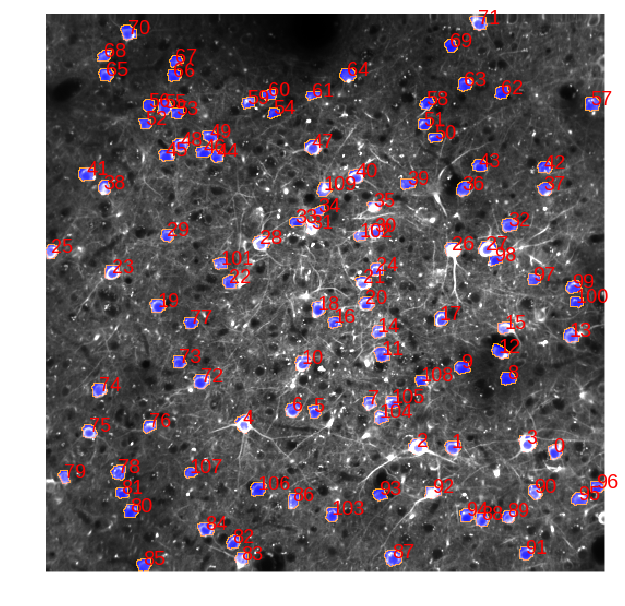

In [17]:
p = 0
region = many(drawn[p].coordinates)

background = mean[:,:,p].astype('float').clip(0,2000)/2000
background = array([background for i in range(3)]).swapaxes(0,1).swapaxes(1,2)

masks = region.mask((512,512), background = 'black', fill='blue', stroke='orange')
blend = maximum(background,masks)

umPerPxX = 600.0/512
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
im = image(blend, ax=ax)
plt.xlim([0, mean.shape[1]]);
plt.ylim([mean.shape[0], 0]);
for s in range(region.count):
    plt.annotate(s=str(s), xy=[region.center[s][1],region.center[s][0]], color='r', size = 20);
#plt.savefig('%s-plane-%s.eps' % (datapath + 'mean/ROIs', plane))

##Match sources

In [18]:
from numpy import concatenate
from numpy import linspace

In [19]:
matches = [auto[p].match(drawn[p]) for p in range(4)]
distance = [[auto[p][j].distance(drawn[p][matches[p][j]]) for j in range(auto[p].count)] for p in range(4)]

In [20]:
matchesDrawn = [drawn[p].match(auto[p]) for p in range(4)]
distanceDrawn = [[drawn[p][j].distance(auto[p][matchesDrawn[p][j]]) for j in range(drawn[p].count)] for p in range(4)]

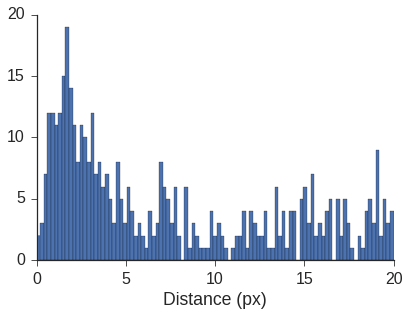

In [21]:
plt.hist(concatenate(distance),bins=linspace(0,20,100));
plt.xlim([0, 20])
plt.xlabel('Distance (px)')
sns.despine()

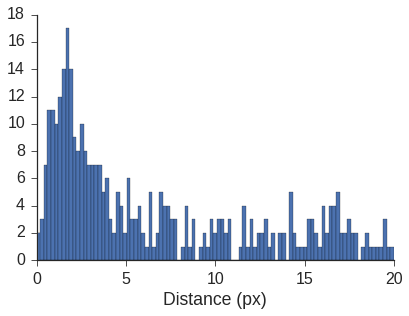

In [22]:
plt.hist(concatenate(distanceDrawn),bins=linspace(0,20,100));
plt.xlim([0, 20])
plt.xlabel('Distance (px)')
sns.despine()

In [23]:
thresh = 5

In [24]:
hit = [[x < thresh for x in plane] for plane in distance]
falseAlarm = [[~x for x in plane] for plane in hit]

In [25]:
hitDrawn = [[x < thresh for x in plane] for plane in distanceDrawn]
miss = [[~x for x in plane] for plane in hitDrawn]

In [26]:
recall = float(sum(concatenate(hitDrawn)))/(sum(concatenate(hitDrawn))+sum(concatenate(miss)))
precision = float(sum(concatenate(hit)))/(sum(concatenate(hit))+sum(concatenate(falseAlarm)))
print recall, precision

0.42600896861 0.283485045514


In [27]:
print sum(concatenate(hit)), (sum(concatenate(hit)) + sum(concatenate(falseAlarm)))

218 769


###plot results

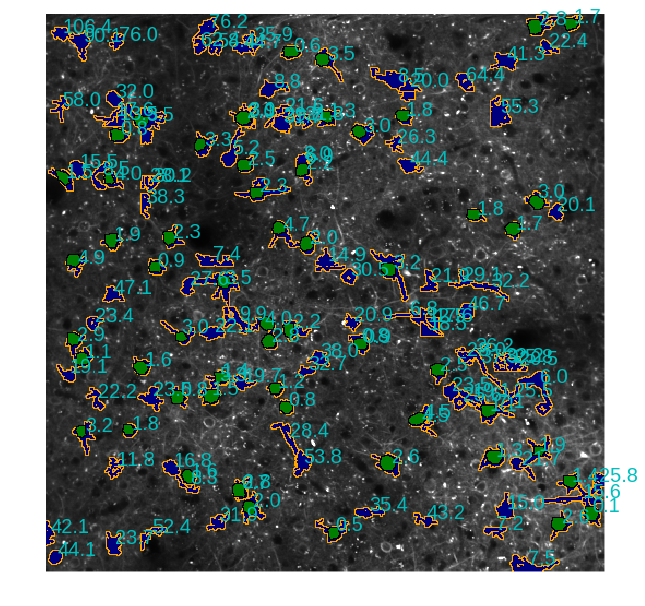

In [28]:
thresh = 5

region = many(auto[p].coordinates)
hitRegion = many([drawn[p][matches[p][i]].coordinates for i in range(auto[p].count) if hit[p][i]])
background = mean[:,:,p].astype('float').clip(0,2000)/2000
background = array([background for i in range(3)]).swapaxes(0,1).swapaxes(1,2)

masks = region.mask((512,512), base = background, fill=[0, 0, 0.5], stroke='orange')
masksH = hitRegion.mask((512,512), base = background, fill=[0, 0.5, 0], stroke='black')
#masksM = miss.mask((512,512), base = background, fill=[0.5, 0, 0], stroke='black')
#blend = maximum(background,masks)
blend = maximum(masks,masksH)

umPerPxX = 600.0/512
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
im = image(blend, ax=ax)
plt.xlim([0, mean.shape[1]]);
plt.ylim([mean.shape[0], 0]);
for s in range(region.count):
    #plt.annotate(s=str(s), xy=[region.center[s][1],region.center[s][0]], color='r', size = 20);
    plt.annotate(s = '%.1f' % distance[p][s], xy=[region.center[s][1]+2,region.center[s][0]-2], color='c', size = 20);

#for s in range(region.count):
#    plt.annotate(s=str(s + ind), xy=[region.center[s][1],region.center[s][0]], color='r', size = 20);
#plt.savefig('%s-plane-%s.eps' % (datapath + 'mean/ROIs', plane))

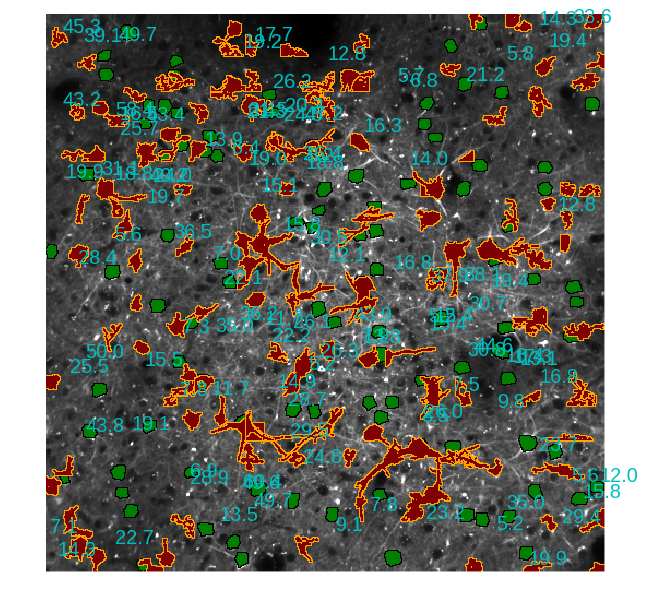

In [29]:
p = 0

regionDrawn = many(drawn[p].coordinates)
regionFA = many([auto[p][i].coordinates for i in range(auto[p].count) if falseAlarm[p][i]])

background = mean[:,:,p].astype('float').clip(0,2000)/2000
background = array([background for i in range(3)]).swapaxes(0,1).swapaxes(1,2)


masks = regionDrawn.mask((512,512), base = background, fill=[0, 0.5, 0], stroke='black')
masksM = regionFA.mask((512,512), base = background, fill=[.5, 0, 0], stroke='orange')
#blend = maximum(background,masks)
blend = maximum(masks,masksM)

umPerPxX = 600.0/512
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
im = image(blend, ax=ax)
plt.xlim([0, mean.shape[1]]);
plt.ylim([mean.shape[0], 0]);
for s in range(region.count):
    #plt.annotate(s=str(s), xy=[region.center[s][1],region.center[s][0]], color='r', size = 20);
    if distance[p][s] > thresh:
        plt.annotate(s = '%.1f' % distance[p][s], xy=[region.center[s][1]+2,region.center[s][0]-2], color='c', size = 20);

#for s in range(region.count):
#    plt.annotate(s=str(s + ind), xy=[region.center[s][1],region.center[s][0]], color='r', size = 20);
#plt.savefig('%s-plane-%s.eps' % (datapath + 'mean/ROIs', plane))

##Show zoomed in patch

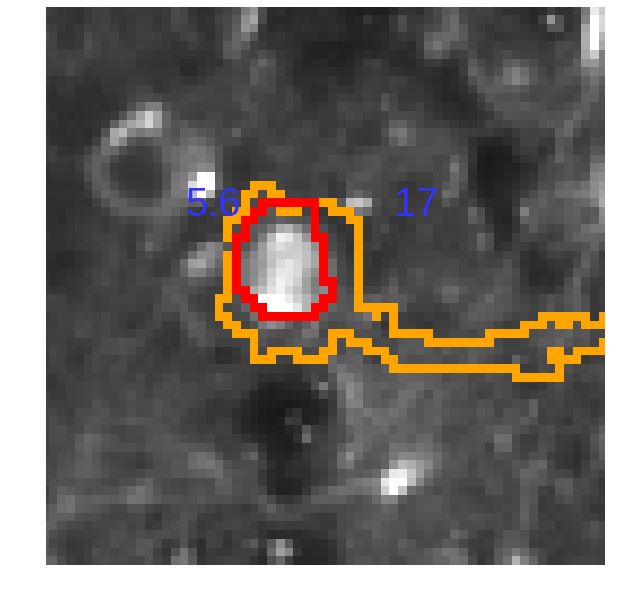

In [116]:
p = 0
n = 17
size = 32

region = one(auto[p][n].coordinates)
regionDrawn = one(drawn[p][matches[p][n]].coordinates)
background = mean[:,:,p].astype('float').clip(0,2000)/2000
background = array([background for i in range(3)]).swapaxes(0,1).swapaxes(1,2)

masks = region.mask((512,512), base = background, fill=None, stroke='orange')
masksD = regionDrawn.mask((512,512), base = background, fill=None, stroke='red')

blend = maximum(masks,masksD)

fig = plt.figure(figsize=[10,10]);
ax = plt.axes();
im = image(blend, ax=ax);
plt.xlim([region.center[1]-size, region.center[1]+size]);
plt.ylim([region.center[0]+size, region.center[0]-size]);
plt.annotate(s=str(n), xy=[region.center[1]+8,region.center[0]-8], color=[.2, .2, 1], size = 40);
plt.annotate(s = '%.1f' % distance[p][n], xy=[region.center[1]-16,region.center[0]-8], color=[.2, .2, 1], size = 40);

## Extract traces

In [38]:
traces = []
for p in range(0,4):
    tmp = SourceModel([array([concatenate((x,[p])) for x in y.coordinates]) for y in auto[p]])
    tmp = tmp.transform(corrected)
    traces.append(tsc.loadSeriesFromArray(tmp).toTimeSeries().normalize('window-fast', window=500).collectValuesAsArray())

In [39]:
tracesDrawn = []
for p in range(0,4):
    tmp = SourceModel([array([concatenate((x,[p])) for x in y.coordinates]) for y in drawn[p]])
    tmp = tmp.transform(corrected)
    tracesDrawn.append(tsc.loadSeriesFromArray(tmp).toTimeSeries().normalize('window-fast', window=500).collectValuesAsArray())

In [40]:
time = [x/frameRate for x in range(traces[0].shape[1])]

## Plot traces

In [82]:
neuronId

array([149, 150, 151, 152])

In [78]:
plane = 0
neuronId = where(hit[plane])[0][39:43]

dat = traces[plane][neuronId]
stacked = dat + -arange(dat.shape[0]).reshape(dat.shape[0], 1) * 1.2
dat = tracesDrawn[plane][[matches[plane][x] for x in neuronId]]
stackedD = dat + -arange(dat.shape[0]).reshape(dat.shape[0], 1) * 1.2

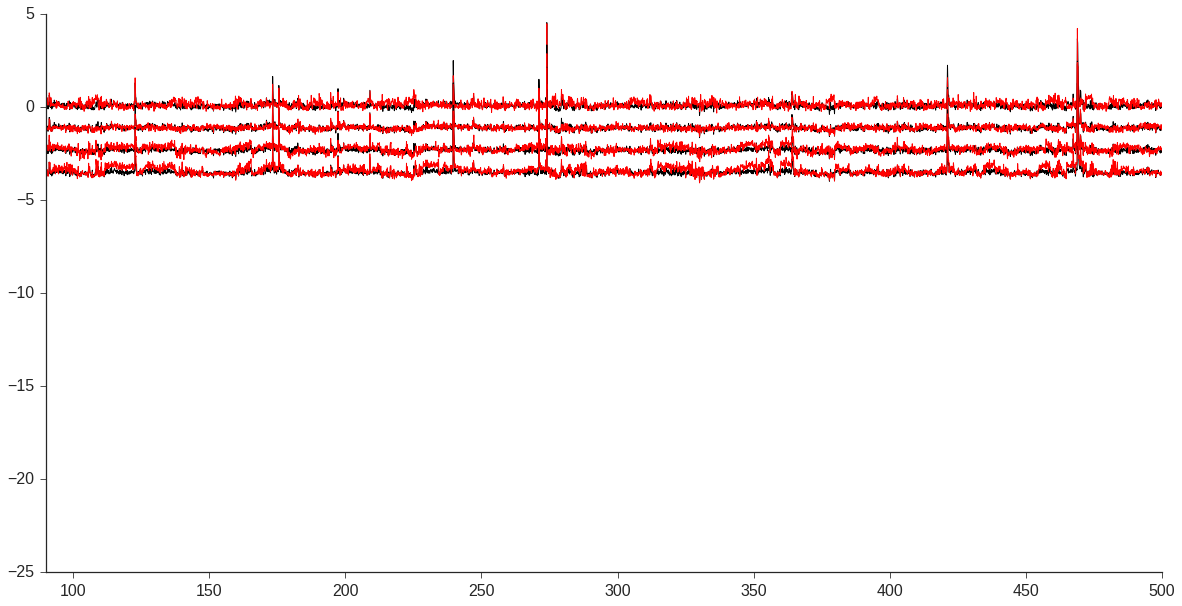

In [81]:
fig = plt.figure(figsize=(20,10))
ax1 = plt.axes()
for t in range(stacked.shape[0]):
    ax1.plot(time,stackedD[t].T, 'k', linewidth=1);
    ax1.plot(time,stacked[t].T, 'r', linewidth=1);
plt.xlim([90, 500])
plt.ylim([-25, 5])
#plt.yticks([0, 2]);
#ax1.axes.get_yaxis().set_visible(False)
sns.despine()
#plt.savefig(datapath + '/traces/traces3.eps')

## Compare traces

####correlate matching traces

In [92]:
from numpy import corrcoef

In [93]:
vals = []
for plane in range(4):
    neuronId = where(hit[plane])[0]

    dat = traces[plane][neuronId]
    datD = tracesDrawn[plane][[matches[plane][x] for x in neuronId]]
    vals.append([corrcoef(dat[i],datD[i])[0,1] for i in range(len(neuronId))])

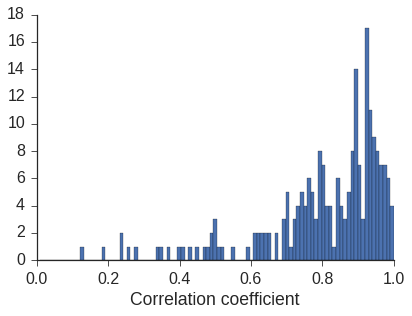

In [94]:
plt.hist(concatenate(vals),bins=linspace(0,1,100));
plt.xlim([0, 1])
plt.xlabel('Correlation coefficient')
sns.despine()

####compare SNR of DF/F

In [95]:
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal

In [96]:
from numpy import exp

In [97]:
def gauss(x, a, mu, sigma):
    return a*exp(-(x-mu)**2/(2*sigma**2))

In [98]:
def fit(x, y):
    popt, pcov = curve_fit(gauss, x, y, p0 = [1, 0, 1])
    return popt

In [99]:
from numpy import histogram

In [100]:
from numpy import percentile

In [101]:
def hist(vals):
    A = histogram(vals,bins=linspace(-.5,2,100))
    x = A[1][:-1]+(A[1][1]-A[1][0])/2
    y = A[0]
    popt = fit(x, y)
    popt[2] = abs(popt[2])
    yFit = gauss(x, *popt)
    FWHM = 2.355*popt[2]
    signal = percentile(vals,95)
    SNR = signal/FWHM
    return x, y, yFit, FWHM, signal, SNR

In [102]:
plane = 0
i = 0

neuronId = where(hit[plane])[0]
vals = tracesDrawn[plane][matches[plane][neuronId[i]]]
x, y, yFit, FWHM, signal, SNR = hist(vals)
print FWHM
print signal
print SNR

0.221442794083
0.291087513541
1.31450433845


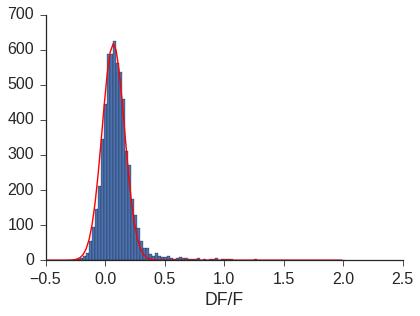

In [103]:
plt.bar(x, y, width = (x[1]-x[0]))
plt.plot(x, yFit, 'r');
plt.xlabel('DF/F')
sns.despine()

In [104]:
vals = traces[plane][neuronId[i]]
x, y, yFit, FWHM, signal, SNR = hist(vals)
print FWHM
print signal
print SNR

0.214961615407
0.309798470797
1.44118041824


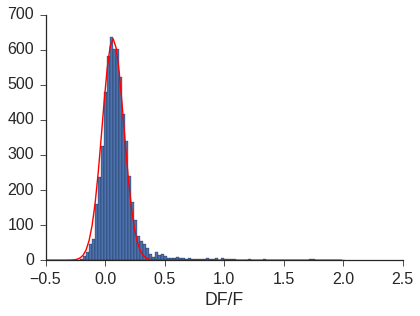

In [105]:
plane = 0
neuronId = 2
plt.bar(x, y, width = (x[1]-x[0]))
plt.plot(x, yFit, 'r');
plt.xlabel('DF/F')
sns.despine()

In [106]:
aSNR = []
for plane in range(4):
    neuronId = where(hit[plane])[0]
    for i in neuronId:
        vals = traces[plane][i]
        x, y, yFit, FWHM, signal, SNR = hist(vals)
        aSNR.append(SNR)

In [107]:
dSNR = []
for plane in range(4):
    neuronId = where(hit[plane])[0]
    for i in neuronId:
        vals = tracesDrawn[plane][matches[plane][i]]
        x, y, yFit, FWHM, signal, SNR = hist(vals)
        dSNR.append(SNR)

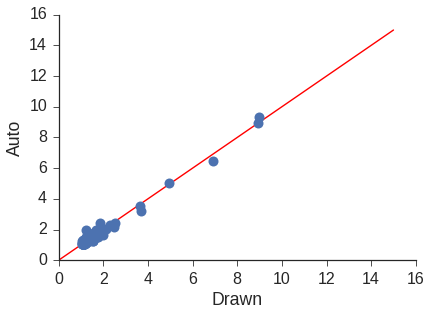

In [108]:
plt.plot([0,15], [0, 15],'r')
plt.plot(dSNR, aSNR, '.', markersize=20)
plt.ylabel('Auto')
plt.xlabel('Drawn')
sns.despine()
#plt.xlim([0, 5])
#plt.ylim([0, 5])

In [109]:
from numpy import log

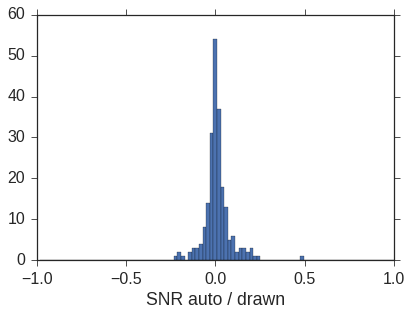

In [110]:
plt.hist([log(aSNR[i]/dSNR[i]) for i in range(len(aSNR))],linspace(-1,1,100));
plt.xlabel('SNR auto / drawn');